In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import log_loss, roc_auc_score
import datetime as dt
import math
from tqdm.notebook import tqdm
import xlearn as xl

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('data.csv', parse_dates=['date_time'], date_parser=pd.to_datetime)
data.head()

/tmp/ipykernel_427/3287559034.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('data.csv', parse_dates=['date_time'], date_parser=pd.to_datetime)


,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


In [3]:
data.drop(['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'], axis=1, inplace=True)

In [4]:
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30,0,0,0,0,0,1,1
1,2021-09-26 22:54:49,1,1,0,0,1,1,1
2,2021-09-26 23:57:20,2,2,3,0,0,1,1
3,2021-09-27 00:04:30,3,3,0,1,1,1,1
4,2021-09-27 00:06:21,4,4,0,1,0,1,1


Изучим наши данные с разных сторон

In [5]:
data.isna().any()

date_time          False
zone_id            False
banner_id          False
campaign_clicks    False
os_id              False
country_id         False
impressions        False
clicks             False
dtype: bool

In [6]:
data.nunique()

date_time          604712
zone_id              3444
banner_id            1633
campaign_clicks       822
os_id                  11
country_id             17
impressions             1
clicks                  2
dtype: int64

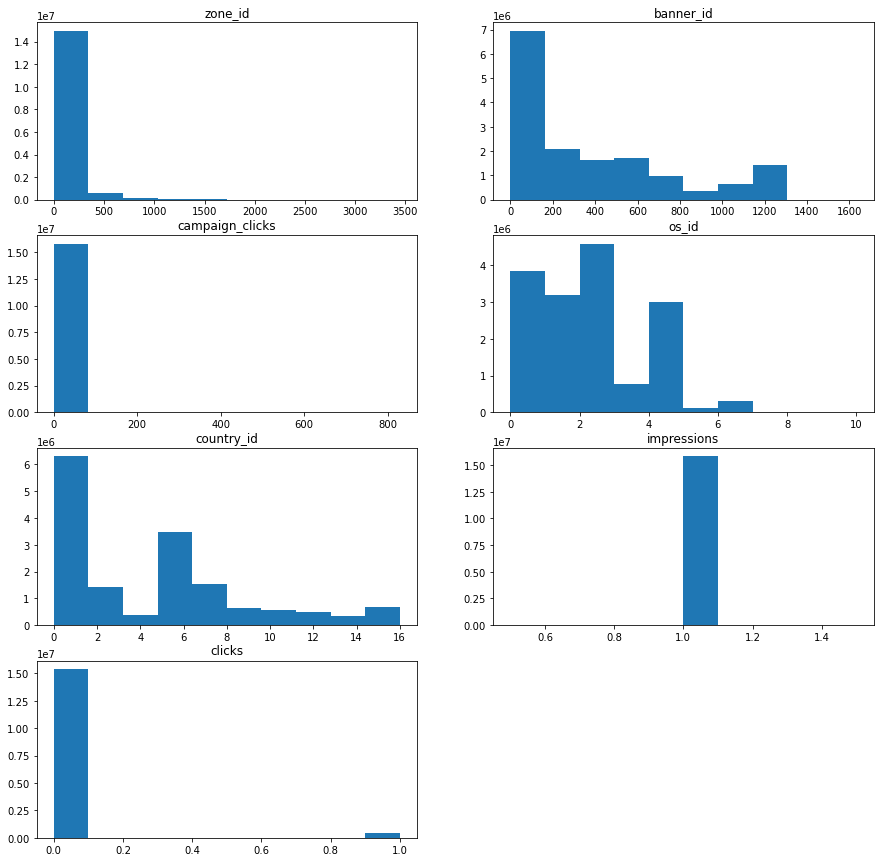

In [7]:
plt.figure(figsize=(15,15))
for i, feature in enumerate(data.columns.values[1:]):
    plt.subplot(4, 2, 1+i)
    plt.hist(data[feature])
    plt.title(feature)
plt.show()

In [8]:
data.date_time.dt.date.value_counts()

date_time
2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
2021-09-01          1
Name: count, dtype: int64

<AxesSubplot:>

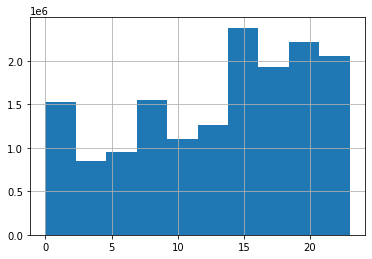

In [9]:
data.date_time.dt.hour.hist()

Из всего этого можно сделать следующие выводы: 

1) Признак impressions -- константа

2) Классы был клик/не было -- несбалансированны

3) В фичах zone_id, banner_id, campaign_clicks, os_id есть классы с маленьким числом элементов

4) В date_time есть 1 выброс

5) Стоит добавить фичу "час"

In [10]:
data.pop('impressions')
data = data[data['date_time'].dt.date != dt.date(2021, 9, 1)]  #Удалили выброс
data['hour'] = data['date_time'].dt.hour #Добавили фичу час

In [11]:
data = data.sort_values('date_time')

In [12]:
test = data[data['date_time'].dt.date == dt.date(2021, 10, 2)]
val = data[data['date_time'].dt.date == dt.date(2021, 10, 1)]
train = data[data['date_time'].dt.date < dt.date(2021, 10, 1)]
print(len(test), len(val), len(train))

2128978 1643448 12049045


In [13]:
test.pop('date_time')
val.pop('date_time')
train.pop('date_time')

8423230    2021-09-26 00:00:00
7683145    2021-09-26 00:00:00
4647065    2021-09-26 00:00:00
11536774   2021-09-26 00:00:00
1442602    2021-09-26 00:00:00
                   ...        
9163452    2021-09-30 23:59:59
13381233   2021-09-30 23:59:59
15357035   2021-09-30 23:59:59
5296942    2021-09-30 23:59:59
6636311    2021-09-30 23:59:59
Name: date_time, Length: 12049045, dtype: datetime64[ns]

С помощью следующей функции преобразуем данные, чтобы их можно было скормить FFM модели

In [14]:
###https://github.com/wngaw/blog/blob/master/xlearn_example/src/utils.py

def _convert_to_ffm(path, df, type, target, numerics, categories, encoder):
    # Flagging categorical and numerical fields
    print('convert_to_ffm - START')
    for x in numerics:
        if(x not in encoder['catdict']):
            print(f'UPDATING CATDICT: numeric field - {x}')
            encoder['catdict'][x] = 0
    for x in categories:
        if(x not in encoder['catdict']):
            print(f'UPDATING CATDICT: categorical field - {x}')
            encoder['catdict'][x] = 1

    nrows = df.shape[0]
    with open(path + str(type) + "_ffm.txt", "w") as text_file:

        # Looping over rows to convert each row to libffm format
        for n, r in tqdm(enumerate(range(nrows))):
            datastring = ""
            datarow = df.iloc[r].to_dict()
            datastring += str(int(datarow[target]))  # Set Target Variable here

            # For numerical fields, we are creating a dummy field here
            for i, x in enumerate(encoder['catdict'].keys()):
                if(encoder['catdict'][x] == 0):
                    # Not adding numerical values that are nan
                    if math.isnan(datarow[x]) is not True:
                        datastring = datastring + " "+str(i)+":" + str(i)+":" + str(datarow[x])
                else:

                    # For a new field appearing in a training example
                    if(x not in encoder['catcodes']):
                        #print(f'UPDATING CATCODES: categorical field - {x}')
                        encoder['catcodes'][x] = {}
                        encoder['currentcode'] += 1
                        #print(f'UPDATING CATCODES: categorical value for field {x} - {datarow[x]}')
                        encoder['catcodes'][x][datarow[x]] = encoder['currentcode']  # encoding the feature

                    # For already encoded fields
                    elif(datarow[x] not in encoder['catcodes'][x]):
                        encoder['currentcode'] += 1
                        #print(f'UPDATING CATCODES: categorical value for field {x} - {datarow[x]}')
                        encoder['catcodes'][x][datarow[x]] = encoder['currentcode']  # encoding the feature

                    code = encoder['catcodes'][x][datarow[x]]
                    datastring = datastring + " "+str(i)+":" + str(int(code))+":1"

            datastring += '\n'
            text_file.write(datastring)

    return encoder

In [15]:
categories = ['zone_id', 'banner_id', 'os_id', 'country_id', 'hour']
numerics = []

In [16]:
encoder = {"currentcode": 0,
           "catdict": {},
           "catcodes": {}}

In [17]:
#encoder = _convert_to_ffm("", train, "train", "clicks", numerics, categories, encoder)

In [18]:
#encoder = _convert_to_ffm("", val, "val", "clicks", numerics, categories, encoder)

In [19]:
#encoder = _convert_to_ffm("", test, "test", "clicks", numerics, categories, encoder)

С помощью grid search подберем лучшие гиперпараметры

In [20]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("train_ffm.txt")
ffm_model.setValidate("val_ffm.txt")
params_grid = {"task": ["binary"],
               "k": [4, 6, 8],
               "lr": [0.1],
               "lambda": [0.001, 0.0001],
               "metric": ["auc"],
               "epoch": [30]}

In [21]:
for params in ParameterGrid(params_grid):
    print(params)
    ffm_model = xl.create_ffm()
    ffm_model.setTrain("train_ffm.txt")
    ffm_model.setValidate("val_ffm.txt")
    ffm_model.fit(params, "model.out")

{'epoch': 30, 'k': 4, 'lambda': 0.001, 'lr': 0.1, 'metric': 'auc', 'task': 'binary'}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 4 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train_ffm.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 4969
[------------] Number of Fi

[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 4969
[------------] Number of Field: 5
[------------] Time cost for reading problem: 8.93 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.55 MB
[------------] Time cost for model initial: 0.00 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss            Test AUC     Time cost (sec)
[    3%      ]     1            0.100362            0.155097            0.784064                4.04
[    6%      ]     2            0.099579            0.155087            0.784095                4.51
[   10%      ]     3            0.099421            0.154657            0.784799                4.76
[   13%      ]     4            0.099346            0.154861            0.784873                4.05
[   16%      ]     5            

[------------] Binary file (train_ffm.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val_ffm.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 4969
[------------] Number of Field: 5
[------------] Time cost for reading problem: 24.81 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 1.55 MB
[------------] Time cost for model initial: 0.00 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss       Test log_loss            Test AUC     Time cost (sec)
[    3%      ]     1            0.098349            0.150222            0.797736                3.46
[    6%      ]     2            0.097156            0.150146            0.799173                3.54
[   10%      ]     3            0.096840            0.149720            0.799873                3.51
[   13%      ]     4            0.096600      

In [23]:
ffm_model.setTest("test_ffm.txt")
ffm_model.predict("model.out", "output.txt")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 4 threads for prediction task.
[ ACTION     ] Load model ...
[------------] Load model from model.out
[------------] Loss function: cross-entropy
[------------] Score function: ffm
[------------] Number of Feature: 4969
[------------] Number of K: 8
[------------] Number of field: 5
[------------] Time cost for loading model: 0.00 (sec)
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (test_ffm.txt.bin) NOT found. Convert text file to binary file.
[--------

In [26]:
y_pred = pd.read_csv('output.txt', header=None)
y_true = test['clicks']
print('roc_auc =', roc_auc_score(y_true, y_pred), 'log_loss =', log_loss(y_true, y_pred))

roc_auc = 0.7912082770314087 log_loss = 1.273015563137955
